# online nets

Deep learning is powerful but computationally expensive, frequently requiring massive compute budgets. In persuit of cost-effective-yet-powerful AI, this work explores and evaluates a heuristic which should lend to more-efficient use of data through online learning.

Goal: evaluate a deep learning alternative capable of true online learning. Solution requirements:

1. catastrophic forgetting should be impossible;
2. all data is integrated into sufficient statistics of fixed dimension;
3. and our solution should have predictive power comparable to deep learning.

## modeling strategy

We will not attempt to derive sufficient statistics for an entire deep net, but instead leverage well-known sufficient statistics for least squares models, 
so will have sufficient statistics per deep net layer. If this can be empirically shown effective, we'll build-out the theory afterwards. 

Recognizing a deep net as a series of compositions, as follows.

$ Y + \varepsilon \approx \mathbb{E}Y = \sigma_3 \circ \beta_3^T \circ \sigma_2 \circ \beta_2^T \circ \sigma_1 \circ \beta_1^T X $

So, we can isolate invidivdual $\beta_j$ matrices using (psuedo-)inverses $\beta_j^{-1}$ like so.

$ \sigma_2^{-1} \circ \beta_3^{-1} \circ \sigma_3^{-1} (Y) \approx  \beta_2^T \circ \sigma_1 \circ \beta_1^T X $

In this example, if we freeze all $\beta_j$'s except $\beta_2$, we are free to update $\hat \beta_2$ using $\tilde Y = \sigma_2^{-1} \circ \beta_3^{-1} \circ \sigma_3^{-1} (Y) $
and $\tilde X = \sigma_1 \circ \beta_1^T X $.

Using a least squares formulation for fitting to $\left( \tilde X, \tilde Y \right)$, we get sufficient statistics per layer.

# model code definitions

In [1]:
import torch

TORCH_TENSOR_TYPE = type(torch.tensor(1)) 

def iterated_diagonals(diag_value, n_rows, n_cols): 
    ## construct diagonal matrix 
    n_diag = min(n_rows, n_cols)
    diag = torch.diag(torch.tensor([diag_value]*n_diag))
    if n_rows > n_cols: 
        ## pad rows 
        pad = n_rows//n_cols + 1
        return torch.cat([diag]*pad, 0)[:n_rows, :n_cols] 
    if n_cols > n_rows: 
        ## pad cols 
        pad = n_cols//n_rows + 1 
        return torch.cat([diag]*pad, 1)[:n_rows, :n_cols] 
    ## no padding 
    return diag 

class OnlineDenseLayer: 
    ''' 
    A single dense net, formulated as a least squares model. 
    ''' 
    def __init__(self, p, q, activation=lambda x:x, activation_inverse=lambda x:x, lam=1., clip=10000., dlamdn=0.): 
        ''' 
        inputs: 
        - p: input dimension 
        - q: output dimension 
        - activation: non-linear function, from R^p to R^q. Default is identity. 
        - activation_inverse: inverse of the activation function. Default is identity. 
        - lam: regularization term 
        - clip: predicted value clipping limit 
        - dlamdn: rate of lambda growth relative to n for online regularization 
        ''' 
        lam = float(lam) 
        clip = float(clip) 
        if dlamdn is not None: 
            dlamdn = float(dlamdn)
        self.__validate_inputs(p=p, q=q, lam=lam, clip=clip, dlamdn=dlamdn) 
        self.p = p 
        self.q = q 
        self.n_fits = 0 
        self.clip = clip 
        self.trainable = True 
        self.activation = activation 
        self.activation_inverse = activation_inverse 
        self.batch_norm_forward_mean = None 
        self.batch_norm_forward_std = None 
        self.batch_norm_forward_n = 0 
        self.batch_norm_backward_mean = None 
        self.batch_norm_backward_std = None 
        self.batch_norm_backward_n = 0 
        self.lam = lam 
        self.dlamdn = dlamdn 
        self.xTy = iterated_diagonals(lam, p+1,q) # +1 for intercept 
        self.yTx = iterated_diagonals(lam, q+1,p) 
        self.xTx_inv = torch.diag(torch.tensor([1./lam]*(p+1))) 
        self.yTy_inv = torch.diag(torch.tensor([1./lam]*(q+1))) 
        self.betaT_forward = torch.matmul(self.xTx_inv, self.xTy) 
        self.betaT_forward = torch.transpose(self.betaT_forward, 0, 1) 
        self.betaT_backward = torch.matmul(self.yTy_inv, self.yTx) 
        self.betaT_backward = torch.transpose(self.betaT_backward, 0, 1) 
        self.x_forward = None 
        self.y_forward = None 
        self.x_backward = None 
        self.y_backward = None 
        pass 
    def copy(self): 
        copied_layer = OnlineDenseLayer(self.p, self.q)
        copied_layer.p = self.p 
        copied_layer.q = self.q 
        copied_layer.n_fits = self.n_fits 
        copied_layer.clip = self.clip 
        copied_layer.trainable = self.trainable 
        copied_layer.activation = self.activation 
        copied_layer.activation_inverse = self.activation_inverse 
        copied_layer.batch_norm_forward_mean = self.batch_norm_forward_mean 
        copied_layer.batch_norm_forward_std = self.batch_norm_forward_std 
        copied_layer.batch_norm_forward_n = self.batch_norm_forward_n 
        copied_layer.batch_norm_backward_mean = self.batch_norm_backward_mean 
        copied_layer.batch_norm_backward_std = self.batch_norm_backward_std 
        copied_layer.batch_norm_backward_n = self.batch_norm_backward_n 
        copied_layer.lam = self.lam 
        copied_layer.dlamdn = self.dlamdn 
        copied_layer.xTx_inv = self.xTx_inv.clone() 
        copied_layer.yTy_inv = self.yTy_inv.clone() 
        copied_layer.xTy = self.xTy.clone() 
        copied_layer.yTx = self.yTx.clone()
        copied_layer.betaT_forward = self.betaT_forward.clone()
        copied_layer.betaT_backward = self.betaT_backward.clone()
        self.x_forward = None 
        self.y_forward = None 
        self.x_backward = None 
        self.y_backward = None
        return copied_layer 
    def forward(self, x): 
        'creates and stores x_forward and y_forward, then returns activation(y_forward)' 
        self.__validate_inputs(x=x, p=self.p)  
        x = self.batch_norm(x, forward=True, fitting=True) 
        self.x_forward = x
        x = torch.cat((torch.tensor([[1.]]), x), dim=0) # intercept 
        self.y_forward = torch.matmul(self.betaT_forward, x) # predict 
        self.y_forward = torch.clip(self.y_forward, -self.clip, self.clip)
        return self.activation(self.y_forward) 
    def backward(self, y): 
        'creates and stores x_backward and y_backward, then returns y_backward' 
        y = self.activation_inverse(y) 
        self.__validate_inputs(y=y, q=self.q) 
        y = self.batch_norm(y, forward=False, fitting=True) 
        self.y_backward = y 
        y = torch.cat((torch.tensor([[1.]]), y), dim=0) 
        self.x_backward = torch.matmul(self.betaT_backward, y) 
        self.x_backward = torch.clip(self.x_backward, -self.clip, self.clip)
        return self.x_backward 
    def forward_fit(self): 
        'uses x_forward and y_backward to update forward model, then returns Sherman Morrison denominator' 
        if self.trainable: 
            self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
            x = torch.cat((torch.tensor([[1.]]), self.x_forward), dim=0) 
            self.xTx_inv, sm_denom = self.sherman_morrison(self.xTx_inv, x, x) 
            ##self.xTx_inv = self.reregularizer(self.xTx_inv, self.dlamdn) ## real online regularization too slow 
            self.xTy += torch.matmul(x, torch.transpose(self.y_backward, 0, 1)) 
            self.betaT_forward = torch.matmul(self.xTx_inv, self.xTy) 
            self.betaT_forward = torch.transpose(self.betaT_forward, 0, 1) 
        return sm_denom 
    def backward_fit(self):
        'uses x_backward and y_forward to update backward model, then returns Sherman Morrison denominator' 
        if self.trainable: 
            self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
            y = torch.cat((torch.tensor([[1.]]), self.y_backward), dim=0) 
            self.yTy_inv, sm_denom = self.sherman_morrison(self.yTy_inv, y, y) 
            ##self.yTy_inv = self.reregularizer(self.yTy_inv, self.dlamdn) 
            self.yTx += torch.matmul(y, torch.transpose(self.x_backward, 0, 1)) 
            self.betaT_backward = torch.matmul(self.yTy_inv, self.yTx) 
            self.betaT_backward = torch.transpose(self.betaT_backward, 0, 1) 
            self.n_fits += 1 ## TODO write general fitting function 
        return sm_denom 
    def forward_fit_temp(self): 
        'uses x_forward and y_backward to update forward model, then returns Sherman Morrison denominator' 
        if self.trainable: 
            self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
            x = torch.cat((torch.tensor([[1.]]), self.x_forward), dim=0) 
            self.xTx_inv_temp, sm_denom = self.sherman_morrison(self.xTx_inv, x, x) 
            ##self.xTx_inv = self.reregularizer(self.xTx_inv, self.dlamdn) ## real online regularization too slow 
            self.xTy_temp = self.xTy + torch.matmul(x, torch.transpose(self.y_backward, 0, 1)) 
            self.betaT_forward_temp = torch.matmul(self.xTx_inv_temp, self.xTy_temp) 
            self.betaT_forward_temp = torch.transpose(self.betaT_forward_temp, 0, 1) 
        return sm_denom 
    def backward_fit_temp(self):
        'uses x_backward and y_forward to update backward model, then returns Sherman Morrison denominator' 
        if self.trainable: 
            self.__validate_inputs(x=self.x_forward, y=self.y_backward, p=self.p, q=self.q) 
            y = torch.cat((torch.tensor([[1.]]), self.y_backward), dim=0) 
            self.yTy_inv_temp, sm_denom = self.sherman_morrison(self.yTy_inv, y, y) 
            ##self.yTy_inv = self.reregularizer(self.yTy_inv, self.dlamdn) 
            self.yTx_temp = self.yTx + torch.matmul(y, torch.transpose(self.x_backward, 0, 1)) 
            self.betaT_backward_temp = torch.matmul(self.yTy_inv_temp, self.yTx_temp) 
            self.betaT_backward_temp = torch.transpose(self.betaT_backward_temp, 0, 1) 
            #self.n_fits += 1 ## TODO write general fitting function 
        return sm_denom 
    def forward_temp(self, x): 
        'creates and stores x_forward and y_forward, then returns activation(y_forward)' 
        self.__validate_inputs(x=x, p=self.p)  
        x = self.batch_norm(x, forward=True, fitting=False) 
        self.x_forward = x
        x = torch.cat((torch.tensor([[1.]]), x), dim=0) # intercept 
        self.y_forward = torch.matmul(self.betaT_forward_temp, x) # predict 
        self.y_forward = torch.clip(self.y_forward, -self.clip, self.clip)
        return self.activation(self.y_forward) 
    def backward_temp(self, y): 
        'creates and stores x_backward and y_backward, then returns y_backward' 
        y = self.activation_inverse(y) 
        self.__validate_inputs(y=y, q=self.q) 
        y = self.batch_norm(y, forward=False, fitting=False) 
        self.y_backward = y 
        y = torch.cat((torch.tensor([[1.]]), y), dim=0) 
        self.x_backward = torch.matmul(self.betaT_backward_temp, y) 
        self.x_backward = torch.clip(self.x_backward, -self.clip, self.clip)
        return self.x_backward 
    def set_n_fits(self, n):
        'resizes sufficient statistic matrices to sample size n'
        if n < 1 or self.n_fits < 1:
            return None 
        self.xTy *= n/self.n_fits 
        self.yTx *= n/self.n_fits 
        self.xTx_inv *= self.n_fits/n 
        self.yTy_inv *= self.n_fits/n 
        self.n_fits = n 
        pass
    def batch_norm(self, x, forward, fitting=True):
        '''
        batch normalize tensor
        inputs:
        - x: (tensor) to be normalized 
        - forward: (boolean) indicates prediction is forward, instead of backward 
        - fitting: (boolean) if in model fitting, update values 
        '''
        ## retrieve 
        if forward:
            m = self.batch_norm_forward_mean 
            s = self.batch_norm_forward_std
            n = self.batch_norm_forward_n 
        else: 
            m = self.batch_norm_backward_mean 
            s = self.batch_norm_backward_std
            n = self.batch_norm_backward_n 
        ## caculate 
        if n == 0: 
            n = 1 
            m = x.mean() 
            s = x.std() 
        else: 
            n += 1 
            m = x.mean()/n + m*(n-1)/n 
            s = x.std()/n + s*(n-1)/n 
        ## store 
        if fitting:
            if forward: 
                self.batch_norm_forward_mean = m 
                self.batch_norm_forward_std = s 
                self.batch_norm_forward_n = n 
            else: 
                self.batch_norm_backward_mean = m
                self.batch_norm_backward_std = s 
                self.batch_norm_backward_n = n 
        ## no dividing by zero 
        if s < 1e-3:
            s = 1e-3 
        return (x - m)/s 
    def reregularize(self, dlamdn=None): 
        if dlamdn is None:
            dlamdn = self.dlamdn 
        self.xTx_inv = self.online_regularizer(self.xTx_inv, dlamdn) 
        self.yTy_inv = self.online_regularizer(self.yTy_inv, dlamdn) 
        pass 
    @staticmethod
    def online_regularizer(m_inv, dlam):
        '''
        Used to expand the regularization sphere as samples grow.
        Applies modified Sherman Morrison formula for numerical efficiency. 
        inputs
        - m_inv: inverse matrix of m 
        - dlam: regularizer to be added on the diagonal 
        returns
         - (m + 1/dlam)^{-1} 
        '''
        if dlam == 0. or dlam is None:
            ## avoid degeneracy 
            return m_inv 
        if callable(dlam):
            dlam = dlam(self.n_fits) 
        dlam_inv = 1/dlam 
        for i in range(m_inv.shape[0]): 
            m_inv -= dlam_inv * torch.matmul(m_inv[:,i].reshape((-1,1)), m_inv[i,:].reshape((1,-1))) / (1. + dlam_inv * m_inv[i,i]) 
        return m_inv  
    @staticmethod 
    def sherman_morrison(inv_mat, vec1, vec2): 
        ''' 
        applies Sherman Morrison updates, (mat + vec1 vec2^T)^{-1} 
        inputs: 
        - inv_mat: an inverted matrix 
        - vec1: a column vector 
        - vec2: a column vector 
        returns: 
        - updated matrix 
        - the Sherman Morrison denominator, for tracking numerical stability 
        ''' 
        v2t = torch.transpose(vec2, 0, 1)
        denominator = 1. + torch.matmul(torch.matmul(v2t, inv_mat), vec1) 
        numerator = torch.matmul(torch.matmul(inv_mat, vec1), torch.matmul(v2t, inv_mat)) 
        updated_inv_mat = inv_mat - numerator / denominator 
        return updated_inv_mat, float(denominator) 
    def __validate_inputs(self, p=None, q=None, lam=None, x=None, y=None, clip=None, dlamdn=None): 
        'raises value exceptions if provided parameters are invalid'
        if q is not None:
            if not isinstance(q, int):
                raise ValueError('`q` must be int!')
            if q <= 0:
                raise ValueError('`q` must be greater than zero!')
        if p is not None:
            if not isinstance(p, int): 
                raise ValueError('`p` must be int!')
            if p <= 0: 
                raise ValueError('`p` must be greater than zero!')
        if lam is not None:
            if not (isinstance(lam, float) or isinstance(lam, int)):
                raise ValueError('`lam` must be float or int!')
            if lam < 0:
                raise ValueError('`lam` must be non-negative!')
        if x is not None and p is not None: 
            if type(x) != TORCH_TENSOR_TYPE:
                raise ValueError('`x` must be of type `torch.tensor`!') 
            if list(x.shape) != [p,1]: 
                raise ValueError('`x.shape` must be `[p,1]`!') 
            if torch.isnan(x).any():
                raise ValueError('`x` contains `nan`!')
            pass 
        if y is not None and q is not None: 
            if type(y) != TORCH_TENSOR_TYPE:
                raise ValueError('`y` must be of type `torch.tensor`!') 
            if list(y.shape) != [q,1]: 
                raise ValueError('`y.shape` must be `[q,1]`') 
            if torch.isnan(y).any():
                raise ValueError('`y` contains `nan`!')
            pass  
        if clip is not None: 
            if type(clip) != float:
                raise ValueError('`clip` my be of type `float`!') 
            if clip <= 0.: 
                raise ValueError('`clip` must be positive!')
            pass
        if dlamdn is not None: 
            if type(dlamdn) not in [float, callable]: 
                raise ValueError('`dlamdn` my be of type `float` or `callable`!') 
            if type(dlamdn) == float:
                if dlamdn < 0.: 
                    raise ValueError('`dlamdn` must be non-negative!') 
            pass
        pass
    pass

class OnlineNet: 
    'online, sequential dense net' 
    def __init__(self, layer_list, dlamdn=0., reregularization_frequency=1000): 
        '''
        initialize an online dense net
        inputs:
        - layer_list: list of OnlineDenseLayers 
        - dlamdn: (float >= 0) regularization rate per n. Disabled if zero 
        - reregularization_frequency: (int > 0) reregularize after fitting this number of samples, since reregularization is computationally expensive
        '''
        ## validate inputs 
        if type(layer_list) != list: 
            raise ValueError('`layer_list` must be of type list!') 
        for layer in layer_list: 
            if not issubclass(type(layer), OnlineDenseLayer):
                raise ValueError('each item in `layer_list` must be an instance of a subclass of `OnlineDenseLayer`!') 
        if type(dlamdn) != float: 
            raise ValueError('`dlamdn` must of type `float`!') 
        if dlamdn < 0.: 
            raise ValueError('`dlamdn` must be non-negative!') 
        if type(reregularization_frequency) != int: 
            raise ValueError('`reregularization_frequency` must be of type `int`!') 
        if reregularization_frequency <= 0: 
            raise ValueError('`reregularization_frequency` must be postive!') 
        ## assign 
        self.layer_list = layer_list 
        self.fit_count = 0 
        self.dlamdn = dlamdn 
        self.reregularization_frequency = reregularization_frequency 
        pass 
    def copy(self):
        copied_layers = [] 
        for layer in self.layer_list:
            copied_layers.append(layer.copy()) 
        copied_net = OnlineNet(copied_layers, 
                dlamdn=self.dlamdn, 
                reregularization_frequency=self.reregularization_frequency)
        return copied_net 
    def forward(self, x): 
        'predict forward'
        for layer in self.layer_list:
            x = layer.forward(x) 
        return x 
    def backward(self, y):
        'predict backward'
        for layer in reversed(self.layer_list): 
            y = layer.backward(y) 
        return y 
    def forward_temp(self, x): 
        'predicts forward with temporary statistics, returns errors' 
        err = 0. 
        n_layers = len(self.layer_list) 
        for idx, layer in enumerate(self.layer_list):
            x_old = layer.activation(layer.y_forward) 
            x = layer.forward_temp(x) 
            if idx + 1 < n_layers:
                ## ignore observed variables 
                err += (x_old - x).abs().sum() 
            #print(f'DEBUG 4: forward cumulative err: {err}') 
        return err 
    def backward_temp(self, y):
        'predicts backward with temporary statistics, returns errors' 
        err = 0.
        n_layers = len(self.layer_list) 
        for idx, layer in enumerate(reversed(self.layer_list)):
            y_old = layer.x_backward 
            y = layer.backward_temp(y)
            if idx + 1 < n_layers: 
                ## ignore observed variables 
                err += (y_old - y).abs().sum() 
            #print(f'DEBUG 3: backward cumulative err: {err}')
        return err 
    def set_n_fits(self, n):
        'resizes sufficient statistic matrices to sample size n'
        for layer in self.layer_list:
            layer.set_n_fits(n)
        pass 
    def fit(self, x, y, eps=.01):#1e-6): ## TODO get convergance guarantee, & remove cherry-picked eps
        'integrates observation pair. Returns Sherman Morrison denominators per layer in (forward, backward) pairs in a list'
        ## set intermediary predictions 
        self.set_ends(x,y)
        self.forward(x) 
        self.backward(y) 
        ## infer intermediary vectors before keeping them 
        ## this'll keep matrix sizes aligned with sample sizes 
        err = 1. + eps  
        idx = 0 
        while err > eps: 
            idx += 1 
            self.set_ends(x,y)
            for layer in self.layer_list: 
                layer.forward_fit_temp() 
                layer.backward_fit_temp() 
            self.set_ends(x,y) 
            err_forward = self.forward_temp(x)
            err_backward = self.backward_temp(y) 
            err = err_forward + err_backward 
            if idx % 1000 == 0:
                print(f'DEBUG 1: err: {err}') 
                print(f'DEBUG 2: err_forward: {err_forward}, err_backward: {err_backward}') 
        ## iterate once more, but keep sufficient statistics 
        sherman_morrison_denominator_list = [] 
        for layer in self.layer_list: 
            forward_smd = layer.forward_fit() 
            backward_smd = layer.backward_fit() 
            sherman_morrison_denominator_list.append((forward_smd, backward_smd)) 
        return sherman_morrison_denominator_list 
    def reregularize(self, dlamdn=None): 
        for layer in self.layer_list: 
            layer.reregularize(dlamdn) 
            pass 
        pass 
    def set_ends(self, x, y):
        'resets observations at network ends'
        self.layer_list[0].x_forward = x 
        self.layer_list[0].x_backward = x 
        self.layer_list[-1].y_forward = y 
        self.layer_list[-1].y_backward = y 
        pass 
    def __reduce_sherman_morrison_denominator_list(self, smd_pair_list):
        'returns the value closest to zero'
        if type(smd_pair_list) != list: 
            raise ValueError('`smd_pair_list` must be of type `list`!')
        if len(smd_pair_list) == 0:
            return None 
        smallest_smd = None 
        for smd_pair in smd_pair_list:
            if type(smd_pair) != tuple:
                raise ValueError('`smd_pair_list` must be list of tuples!')
            if smallest_smd is None: 
                smallest_smd = smd_pair[0] 
            if abs(smallest_smd) > abs(smd_pair[0]): 
                smallest_smd = smd_pair[0] 
            if abs(smallest_smd) > abs(smd_pair[1]):
                smallest_smd = smd_pair[1] 
        return float(smallest_smd) 
    def __call__(self, x, y=None): 
        '''
        If only x is given, a prediction is made and returned.
        If x and y are given, then the model is updated, and returns
        - the prediction
        - the sherman morrison denominator closest to zero, for tracking numerical stability
        '''
        y_hat = self.forward(x) 
        if y is None: 
            return y_hat 
        self.backward(y) 
        smd_pair_list = self.fit(x,y) 
        smallest_smd = self.__reduce_sherman_morrison_denominator_list(smd_pair_list) 
        self.fit_count += 1 
        if self.fit_count % self.reregularization_frequency == 0:
            if self.dlamdn is not None: 
                ## dividing by self.reregularization_frequency ensures mathematical equivalency to reregularizing with every step 
                self.reregularize(self.dlamdn/self.reregularization_frequency) 
            else:
                ## use per-layer dlamdn values 
                self.reregularize() 
        return y_hat, smallest_smd 

## tests 

## test 1: sherman morrison 
a = torch.tensor([[2., 1.], [1., 2.]]) 
b = torch.tensor([[.1],[.2]]) 
sm_inv, _ = OnlineDenseLayer.sherman_morrison(torch.inverse(a),b,b) 
num_inv = torch.inverse(a+torch.matmul(b, torch.transpose(b,0,1))) 
err = float(torch.abs(sm_inv - num_inv).sum()) 
assert(err < 1e-5) 

## test 2: online regularization sherman morrison 
a = torch.tensor([[2., 1.], [1., 2.]]) 
b = torch.tensor([[.1, 0.], [0., .1]])
or_inv = OnlineDenseLayer.online_regularizer(torch.inverse(a), 10.) 
num_inv = torch.inverse(a+b) 
err = float(torch.abs(or_inv - num_inv).sum()) 
assert(err < 1e-5) 

# first experiment: mnist classification

In [2]:
from tqdm import tqdm
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1)
test_loader = torch.utils.data.DataLoader(dataset2)

n_labels = 10 
lam = 100. 
dlamdn = 10. 
reregularization_frequency = 1000 
clip = 100. 

## activation functions 
## torch.sigmoid 
inv_sigmoid = lambda x: -torch.log((1/(x+1e-8))-1) 
leaky_relu_alpha = .1 
leaky_relu = lambda x: (x > 0)*x + (x <= 0)*x*leaky_relu_alpha 
inv_leaky_relu = lambda x: (x > 0)*x + (x <= 0)*x/leaky_relu_alpha 

model = OnlineNet( 
    layer_list = [ 
        OnlineDenseLayer(p=1*1*28*28, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=n_labels, activation=torch.sigmoid, activation_inverse=inv_sigmoid, lam=lam, clip=clip) 
    ], 
    reregularization_frequency = reregularization_frequency, 
    dlamdn = dlamdn 
) 

def build_data(image, label): 
    'format data from iterator for model' 
    y = torch.tensor([1. if int(label[0]) == idx else 0. for idx in range(n_labels)]) ## one-hot representation 
    x = image.reshape([-1]) ## flatten 
    ## shrink so sigmoid inverse is well-defined 
    y = y*.90 + .05 
    ## reshape to column vectors 
    x = x.reshape([-1,1]) 
    y = y.reshape([-1,1]) 
    return x, y 

def match(y, y_hat):
    y = y.reshape(-1)
    y_hat = y_hat.reshape(-1)
    if y.argmax() == y_hat.argmax():
        return 1.
    return 0. 

def run(data_iterable, fit=True, max_iters=None, model=model):
    '''
    fit or predict on dataset 
    inputs:
    - data_iterable: an iterable of (image, label) pairs
    - fit: (bool) are we integrating the (image, label) pair into the model or just predicting?
    - max_iters: (int or None) if int then cap fit/predict iters at this amount, otherwise run the whole iterable 
    - model: (OnlineDenseNet) the model to update in-place 
    output: 
    - errs: a list of model errors 
    - stab: a list of numerical stability statistics 
    - y_std: a list of y_hat standard deviations 
    - acc: a list of running average accuracies 
    side-effects: 
    - model is updated in-place 
    '''
    ## init stats 
    errs = [] 
    stab = [] 
    y_std = [] 
    acc = [0.] 
    ## get data 
    pbar = tqdm(data_iterable)
    n_iters = 0 
    for [image, label] in pbar: 
        n_iters += 1 
        ## get a datum 
        x, y = build_data(image, label) 
        ## fit or predict 
        if fit: 
            y_hat, stability = model(x, y) 
        else:
            y_hat = model(x) 
            stability = 1. 
        ## stats 
        err = float((y - y_hat).abs().sum()) 
        errs.append(err) 
        stab.append(stability) 
        std = float(y_hat.std()) 
        y_std.append(std) 
        acc_n = max(len(acc), 1000) 
        acc.append(match(y,y_hat)/acc_n + acc[-1]*(acc_n-1)/acc_n) 
        pbar.set_description(f'acc: {acc[-1]:.5f}, err: {err:.5f}, y_std: {std:.5f}, stab: {stability:.5f}') 
        if max_iters is not None: 
            if n_iters > max_iters:
                return errs, stab, y_std, acc
    return errs, stab, y_std, acc 

def test(data_iterable, model, max_iters=None): 
    'calculates accuracy correctly' 
    hits = 0 
    n = 0 
    n_iters = 0 
    for image, label in tqdm(data_iterable):
        x, y = build_data(image, label) 
        y_hat = model(x) 
        if match(y, y_hat) == 1:
            hits += 1 
        n += 1
    return hits/n  

errs, stab, y_std, acc = run(train_loader, fit=True, max_iters=10000) 

acc: 0.80417, err: 3.07254, y_std: 0.19003, stab: 1.00088:  17%|█▋        | 10000/60000 [05:39<28:16, 29.48it/s]  


acc


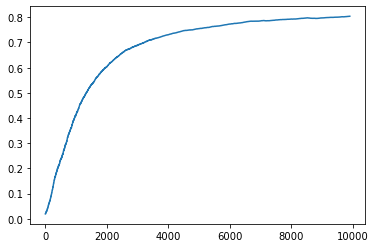

In [3]:
import matplotlib.pyplot as plt 

print('acc')
plt.plot(acc[100:])
plt.show()

errs


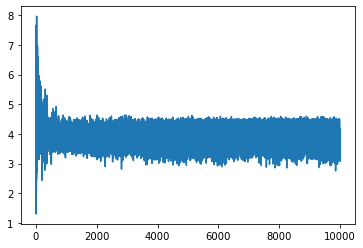

In [4]:
print('errs')
plt.plot(errs)
plt.show()

y_std


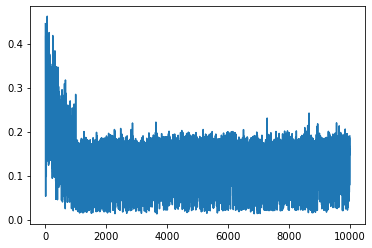

In [5]:
print('y_std')
plt.plot(y_std)
plt.show()

stab


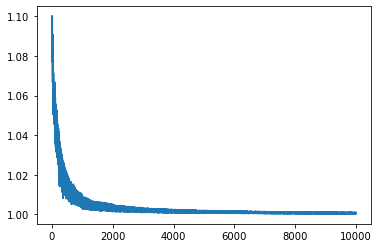

In [6]:
print('stab')
plt.plot(stab)
plt.show()

In [7]:
## test dataset 
errs, stab, y_std, acc = run(test_loader, fit=False, max_iters=10000) 

acc: 0.82273, err: 3.06970, y_std: 0.18997, stab: 1.00000: 100%|██████████| 10000/10000 [00:38<00:00, 261.36it/s]


# hypothesis test 1: does this solve catestrophic forgetting? 

Least squares' sufficient statistics have finite dimension and closed-form online update equations which guarantee perfect transfer learning. 
Our use of one least squares estimator per deep net layer enjoys a series of such sufficient statistics, but is only heuristically simlar to the mathematical guarantees of least squares. 
Nevertheless, we have proceeded hypothesizing some degree of a transfer learning benefit. 
In this section, we test this hypothesis. 

To test our hypothesis, we will subsample MNIST into two parts: initial and expanded. 
The initial portion will include digits 0 through 7, and expanded will only include digits 8 and 9. 
We will first fit our model to the initial dataset and then _transfer learn_ by fitting to the expanded dataset. 
If our hypothesis is true, transfer learning should be maintained and thus catastrophic forgetting avoided, so we'd expect the updated model to retain the ability to predict on digits 0 through 7.

In [8]:
## build data 
min_train_samples = 10000 
min_test_samples = 10000 

def hypothesis_1_sampler(data_loader, min_samples):
    '''
    randomly samples data for hypothesis test 1
    '''
    ## init empty datasets 
    initial = [] 
    expanded = [] 
    for pair in tqdm(data_loader): 
        if pair[1] > 7: 
            expanded.append(pair) 
        else: 
            initial.append(pair) 
            pass 
        if len(expanded) > min_samples and len(initial) > min_samples: 
            return initial, expanded 
    return initial, expanded 

train_initial, train_expanded = hypothesis_1_sampler(train_loader, min_train_samples) 
test_initial, test_expanded = hypothesis_1_sampler(test_loader, min_test_samples) 

100%|██████████| 10000/10000 [00:03<00:00, 2724.86it/s]


#### Fitting on 0 through 7 

In [9]:
## Get a fresh model 
hypothesis_1_model = OnlineNet( 
    layer_list = [ 
        OnlineDenseLayer(p=1*1*28*28, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=100, activation=leaky_relu, activation_inverse=inv_leaky_relu, lam=lam, clip=clip), 
        OnlineDenseLayer(p=100, q=n_labels, activation=torch.sigmoid, activation_inverse=inv_sigmoid, lam=lam, clip=clip) 
    ], 
    reregularization_frequency = reregularization_frequency, 
    dlamdn = dlamdn 
) 

print('fit on 0-7') 
_, _, _, acc_train_initial = run(train_initial, fit=True, max_iters=10000, model=hypothesis_1_model) 

acc: 0.85215, err: 4.09349, y_std: 0.08723, stab: 1.00033:  25%|██▍       | 10000/40798 [12:41<39:06, 13.13it/s]  


fit on 0-7


#### test on 0 through 7 before transfer learning 

In [10]:
print('test on 0-7 before transfer learning') 
_, _, _, acc_test_initial_before = run(test_initial, fit=False, max_iters=10000, model=hypothesis_1_model) 

acc: 0.85991, err: 3.10194, y_std: 0.18904, stab: 1.00000: 100%|██████████| 8017/8017 [00:31<00:00, 258.34it/s]


test on 0-7 before transfer learning


#### fit on 8 and 9 

In [11]:
m = hypothesis_1_model.copy() 
m.layer_list[0].yTy_inv[:5,:5]

tensor([[ 8.8766e-04, -3.1199e-05, -4.3922e-05, -4.1058e-05, -1.1939e-06],
        [-3.1199e-05,  8.6331e-04, -6.3775e-05, -5.9775e-05, -2.3302e-06],
        [-4.3922e-05, -6.3775e-05,  8.1801e-04, -8.4883e-05, -2.0999e-06],
        [-4.1058e-05, -5.9775e-05, -8.4883e-05,  8.2992e-04, -1.9074e-06],
        [-1.1939e-06, -2.3302e-06, -2.0999e-06, -1.9074e-06,  8.1278e-04]])

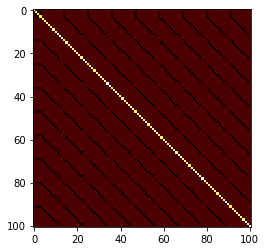

In [12]:
import matplotlib.pyplot as plt

a = m.layer_list[1].xTx_inv.numpy()
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [13]:
for layer in hypothesis_1_model.layer_list:
    print(f'xTx: {1./layer.xTx_inv.diag().mean()}')
    print(f'yTy: {1./layer.yTy_inv.diag().mean()}')
    print(f'xTy: {layer.xTy.diag().mean()}')
    print(f'yTx: {layer.yTx.diag().mean()}')

xTx: 1659.5142822265625
yTy: 1205.6951904296875
xTy: 353.903076171875
yTx: 4330.2265625
xTx: 1278.5374755859375
yTy: 1201.4884033203125
xTy: -261.09613037109375
yTx: 9353.6884765625
xTx: 1215.8984375
yTy: 1199.0355224609375
xTy: -751.804443359375
yTx: 8863.8681640625
xTx: 1210.088623046875
yTy: 3315.27783203125
xTy: -309.90557861328125
yTx: 8203.30078125


In [14]:
## Things that haven't worked: 
## - matrix resizing 
## - iterating on temp matrices 

print('fit on 8-9') 
hypothesis_1_model_copy = hypothesis_1_model.copy() 
#hypothesis_1_model_copy.set_n_fits(1000) 
for layer in hypothesis_1_model_copy.layer_list:
    print(f'xTx: {1./layer.xTx_inv.diag().mean()}')
    print(f'yTy: {1./layer.yTy_inv.diag().mean()}')
    print(f'xTy: {layer.xTy.diag().mean()}')
    print(f'yTx: {layer.yTx.diag().mean()}')

fit on 8-9
xTx: 1659.5142822265625
yTy: 1205.6951904296875
xTy: 353.903076171875
yTx: 4330.2265625
xTx: 1278.5374755859375
yTy: 1201.4884033203125
xTy: -261.09613037109375
yTx: 9353.6884765625
xTx: 1215.8984375
yTy: 1199.0355224609375
xTy: -751.804443359375
yTx: 8863.8681640625
xTx: 1210.088623046875
yTy: 3315.27783203125
xTy: -309.90557861328125
yTx: 8203.30078125


In [26]:
## copy, adjust, and transfer-learn
## re-regularize 
hypothesis_1_model_copy.reregularize(1./10.) 
## adjust sample sizes per layer 
hypothesis_1_model_copy.layer_list[0].set_n_fits(1000)
hypothesis_1_model_copy.layer_list[1].set_n_fits(1000)
hypothesis_1_model_copy.layer_list[2].set_n_fits(1000)
hypothesis_1_model_copy.layer_list[3].set_n_fits(100)
_, _, _, acc_train_expanded = run(train_expanded, fit=True, max_iters=10000, model=hypothesis_1_model_copy) 
### hypothesis: copy broken, test: reassess test set 
#_, _, _, acc_test_initial_before = run(test_initial, fit=False, max_iters=10000, model=hypothesis_1_model_copy) 

acc: 0.62794, err: 3.81652, y_std: 0.15967, stab: 1.00010: 100%|█████████▉| 10000/10001 [04:37<00:00, 36.09it/s]


acc_train_expanded


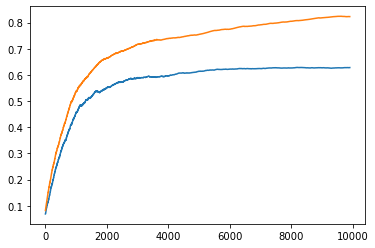

In [27]:
print('acc_train_expanded')
plt.plot(acc_train_expanded[100:])
plt.plot(acc[100:])
plt.show()

#### test on 0 through 7 after transfer learning

In [23]:
print('test on 0-7 after transfer learning') 
_, _, _, acc_train_initial_after = run(test_initial, fit=False, max_iters=10000, model=hypothesis_1_model_copy) 

acc: 0.00050, err: 4.53175, y_std: 0.14510, stab: 1.00000: 100%|██████████| 8017/8017 [00:28<00:00, 280.41it/s]


test on 0-7 after transfer learning


#### test on 8 and 9 after transfer learning 

In [28]:
print('test on 8-9 after transfer learning') 
_, _, _, acc_test_expanded = run(test_expanded, fit=False, max_iters=10000, model=hypothesis_1_model_copy) 

acc: 0.52221, err: 3.81810, y_std: 0.16008, stab: 1.00000: 100%|██████████| 1983/1983 [00:06<00:00, 284.18it/s]


test on 8-9 after transfer learning


# scratch space

ideas
- to improve accuracies:
  - larger models, likely needs GPUs 
  - hyperparamter tuning: try different paths for $\frac{\partial \lambda}{\partial n}(n)$
- to explore strength of transfer learning result
  - compare against a good competing method 
  - ... $\leftarrow$ really need more here

# Conclusion

I'm not done yet

# scatch space 

$\hat \theta_{MLE} := \text{arg max}_\theta f_X(X; \theta) = \text{arg max}_\theta n^{-1} f_X(X; \theta) \to \text{arg max}_\theta \mathbb{E} f_X(X; \theta) \text{ as } {n \to \infty} $

$\hat \beta := \text{arg min}_\beta \|y - x \beta \|^2 + \lambda(n) \| \beta \|^2 = \left( x^Tx + \lambda(n) \right)^{-1} x^Ty = \left(X_{n-1}^TX_{n-1} + x_n^T x_n + \lambda(n) \right)^{-1} \left(X_{n-1}^TY_{n-1} + x_n^T y_n \right) $

$ = \frac{n}{n} \left( x^Tx + \lambda(n) \right)^{-1} x^Ty $

$ = \left( \frac{x^Tx}{n} + \frac{\lambda(n)}{n} \right)^{-1} \frac{x^Ty}{n} $

Apply the SLLN $\left( n^{-1}\sum_{i=1}^n X_i \to \mathbb{E}X_1 \text{ a.s. if } X_i \text{ iid} \right)$.

$ = \left( \mathbb{E}X^TX + \frac{\lambda(n)}{n} \right)^{-1} \mathbb{E}X^TY $